In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')

In [6]:
#load dataset
df = pd.read_csv('traffic-prediction-dataset/traffic.csv')

In [12]:
#display basic info and initial data checks
print("First 5 rows:\n", df.head(5))
print("\nShape of dataset:", df.shape)
print("\nDataset info:")
df.info()

First 5 rows:
               DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041

Shape of dataset: (48120, 4)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [13]:
#check missing and duplicate values
null_values = df.isnull().sum()
duplicate_values = df.duplicated().sum()
print("\nNull values:\n", null_values)
print("\nDuplicate values:", duplicate_values)


Null values:
 DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

Duplicate values: 0


In [15]:
# Handling missing values only for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns  # Select only numeric columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())  # Fill missing values in numeric columns with median

# If you want to drop rows where DateTime is missing (if that occurs), you can do so:
df.dropna(subset=['DateTime'], inplace=True)  # Drop rows where DateTime is missing

In [16]:
# Statistical summary of the dataset
print("\nDataset description:\n", df.describe())


Dataset description:
            Junction      Vehicles            ID
count  48120.000000  48120.000000  4.812000e+04
mean       2.180549     22.791334  2.016330e+10
std        0.966955     20.750063  5.944854e+06
min        1.000000      1.000000  2.015110e+10
25%        1.000000      9.000000  2.016042e+10
50%        2.000000     15.000000  2.016093e+10
75%        3.000000     29.000000  2.017023e+10
max        4.000000    180.000000  2.017063e+10


In [17]:
# Scaling the 'Vehicles' feature
scaler = StandardScaler()
df['Vehicles_scaled'] = scaler.fit_transform(df[['Vehicles']])

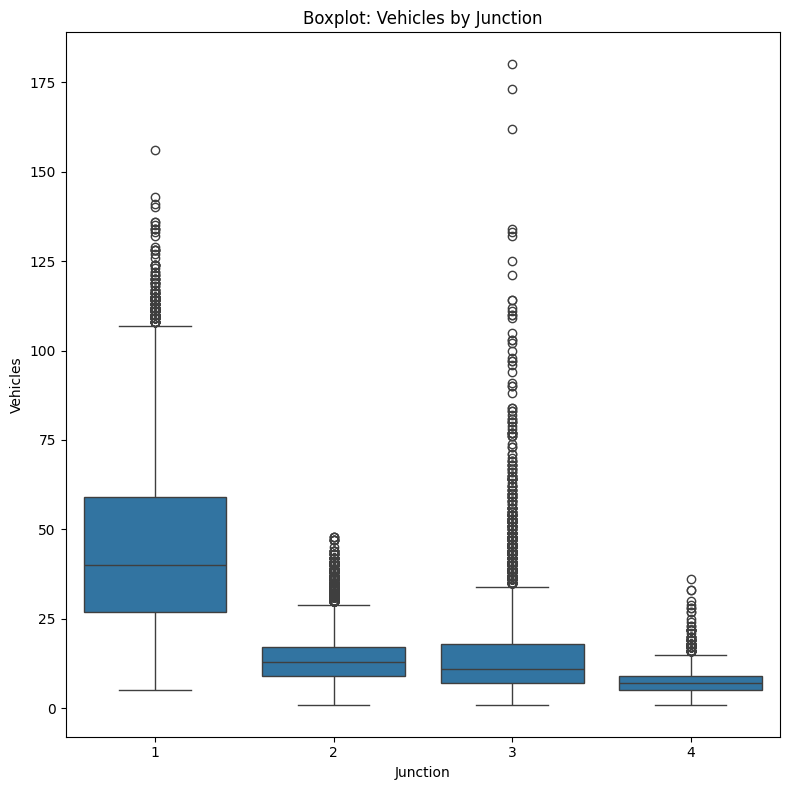

In [18]:
# Boxplot to detect outliers based on 'Vehicles'
plt.figure(figsize=(8, 8))
sns.boxplot(x='Junction', y='Vehicles', data=df)
plt.xlabel('Junction')
plt.ylabel('Vehicles')
plt.title('Boxplot: Vehicles by Junction')
plt.tight_layout()
plt.show()

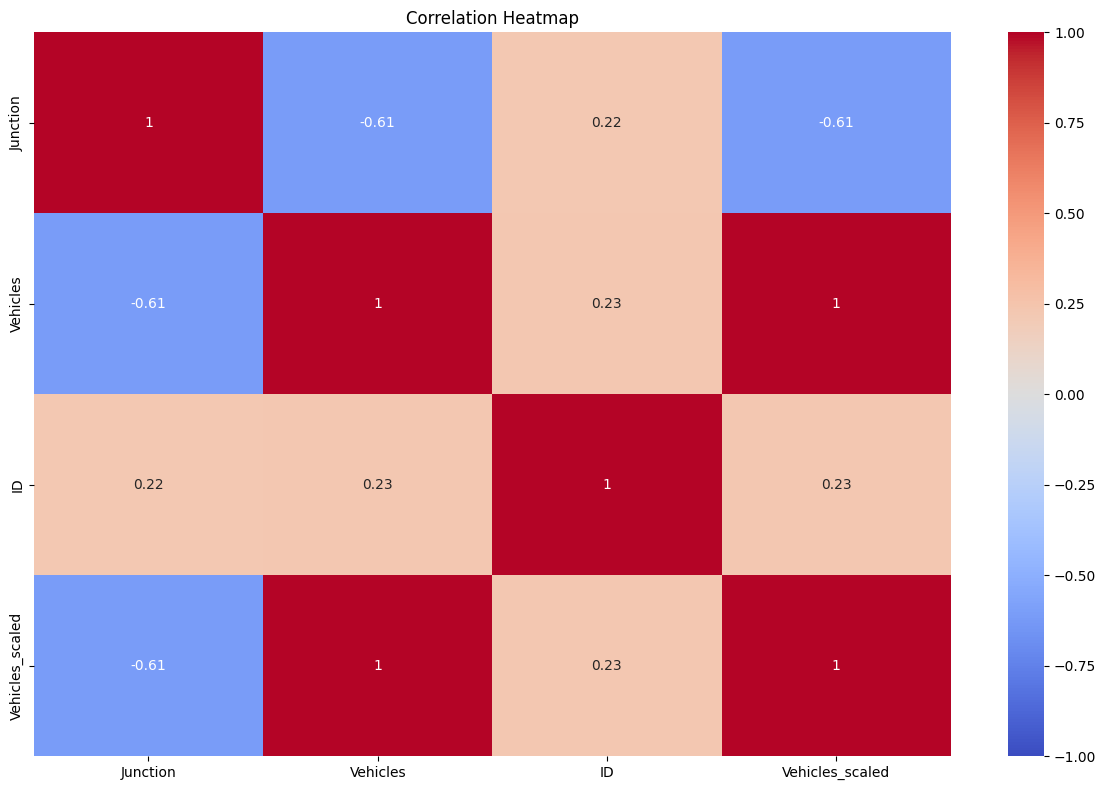

In [21]:
# Select only numeric columns for correlation heatmap
numeric_cols = df.select_dtypes(include=[np.number])

# Correlation heatmap for numeric columns only
plt.figure(figsize=(12, 8))  # Adjust the size to a reasonable figure
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [23]:
# Function to detect outliers using IQR method
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

In [24]:
# Detecting outliers for all junctions using IQR
outliers_iqr = pd.concat([detect_outliers(df[df['Junction'] == i], 'Vehicles') for i in df['Junction'].unique()])

print("\nOutliers detected using IQR:\n", outliers_iqr)


Outliers detected using IQR:
                   DateTime  Junction  Vehicles           ID  Vehicles_scaled
9540   2016-12-02 12:00:00         1       120  20161202121         4.684790
10620  2017-01-16 12:00:00         1       120  20170116121         4.684790
10964  2017-01-30 20:00:00         1       112  20170130201         4.299245
11294  2017-02-13 14:00:00         1       143  20170213141         5.793231
11295  2017-02-13 15:00:00         1       134  20170213151         5.359493
...                    ...       ...       ...          ...              ...
48113  2017-06-30 17:00:00         4        16  20170630174        -0.327296
48114  2017-06-30 18:00:00         4        17  20170630184        -0.279103
48116  2017-06-30 20:00:00         4        30  20170630204         0.347408
48117  2017-06-30 21:00:00         4        16  20170630214        -0.327296
48118  2017-06-30 22:00:00         4        22  20170630224        -0.038137

[1558 rows x 5 columns]


In [25]:
# Isolation Forest for advanced outlier detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['outlier'] = iso_forest.fit_predict(df[['Vehicles_scaled']])

In [26]:
# Filter outliers detected by Isolation Forest
outliers_iso = df[df['outlier'] == -1]
print("\nOutliers detected using Isolation Forest:\n", outliers_iso)


Outliers detected using Isolation Forest:
                   DateTime  Junction  Vehicles           ID  Vehicles_scaled  \
2603   2016-02-17 11:00:00         1        70  20160217111         2.275133   
5579   2016-06-20 11:00:00         1        70  20160620111         2.275133   
5795   2016-06-29 11:00:00         1        76  20160629111         2.564292   
5796   2016-06-29 12:00:00         1        70  20160629121         2.275133   
6083   2016-07-11 11:00:00         1        79  20160711111         2.708871   
...                    ...       ...       ...          ...              ...   
47477  2017-06-04 05:00:00         4         1  20170604054        -1.050193   
48004  2017-06-26 04:00:00         4         1  20170626044        -1.050193   
48028  2017-06-27 04:00:00         4         1  20170627044        -1.050193   
48029  2017-06-27 05:00:00         4         1  20170627054        -1.050193   
48030  2017-06-27 06:00:00         4         1  20170627064        -1.050193

In [27]:
# Convert 'DateTime' to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])
outliers_iqr['DateTime'] = pd.to_datetime(outliers_iqr['DateTime'])
outliers_iso['DateTime'] = pd.to_datetime(outliers_iso['DateTime'])

In [28]:
# Feature engineering: creating additional time-based features
df['day_of_week'] = df['DateTime'].dt.day_name()
df['hour'] = df['DateTime'].dt.hour
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
df['is_peak_hour'] = df['hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)

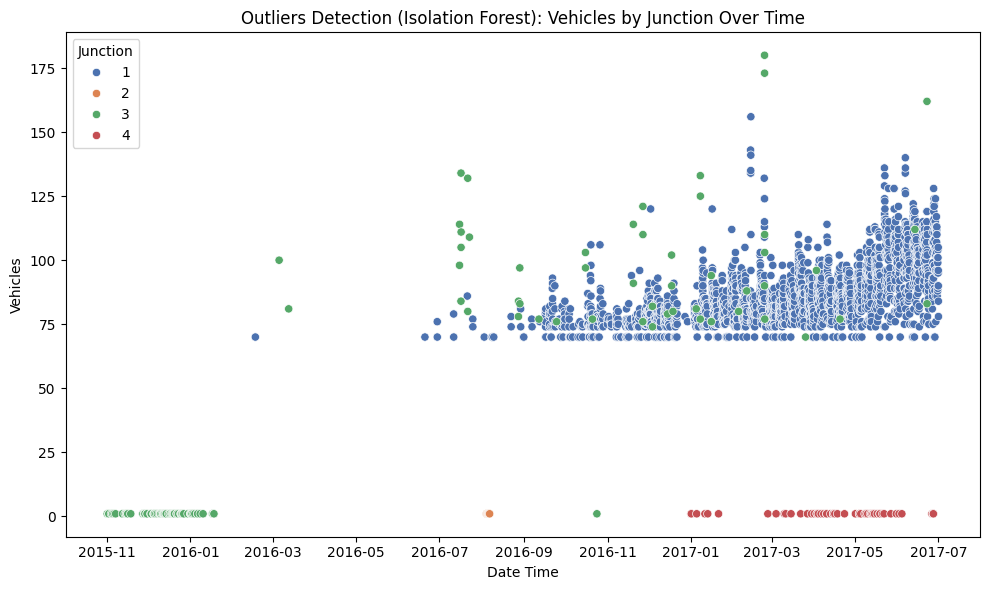

In [29]:
# Plot outliers detected by Isolation Forest over time
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DateTime', y='Vehicles', hue='Junction', data=outliers_iso, palette='deep')
plt.title('Outliers Detection (Isolation Forest): Vehicles by Junction Over Time')
plt.xlabel('Date Time')
plt.ylabel('Vehicles')
plt.tight_layout()
plt.show()

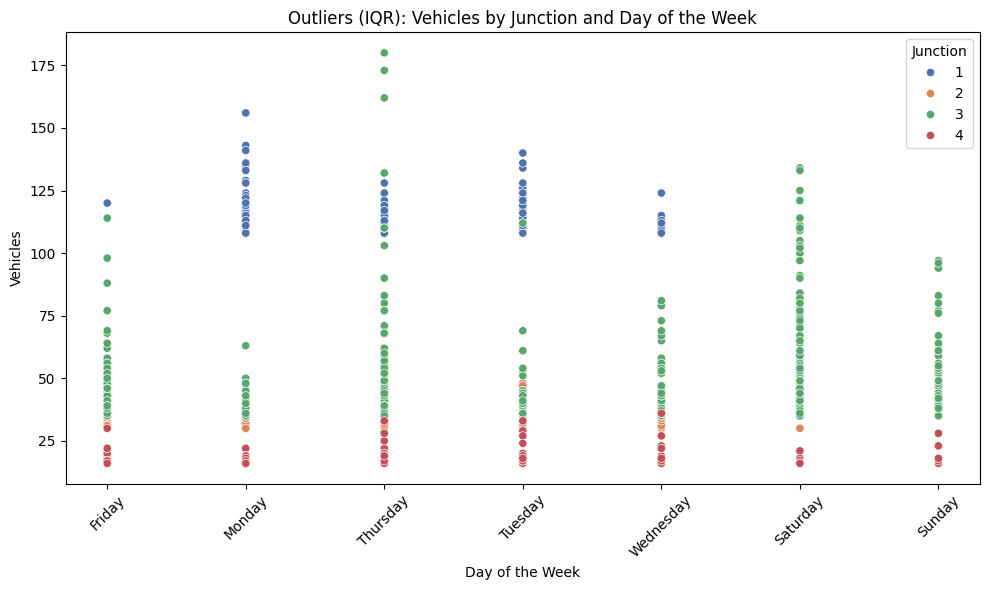

In [31]:
# Ensure DateTime is in datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])
outliers_iqr['DateTime'] = pd.to_datetime(outliers_iqr['DateTime'])  # Confirming for outliers_iqr as well

# Create the day_of_week column for outliers_iqr
outliers_iqr['day_of_week'] = outliers_iqr['DateTime'].dt.day_name()

# Plotting outliers detected by IQR method by day of the week
plt.figure(figsize=(10, 6))
sns.scatterplot(x='day_of_week', y='Vehicles', hue='Junction', data=outliers_iqr, palette='deep')
plt.title('Outliers (IQR): Vehicles by Junction and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Vehicles')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

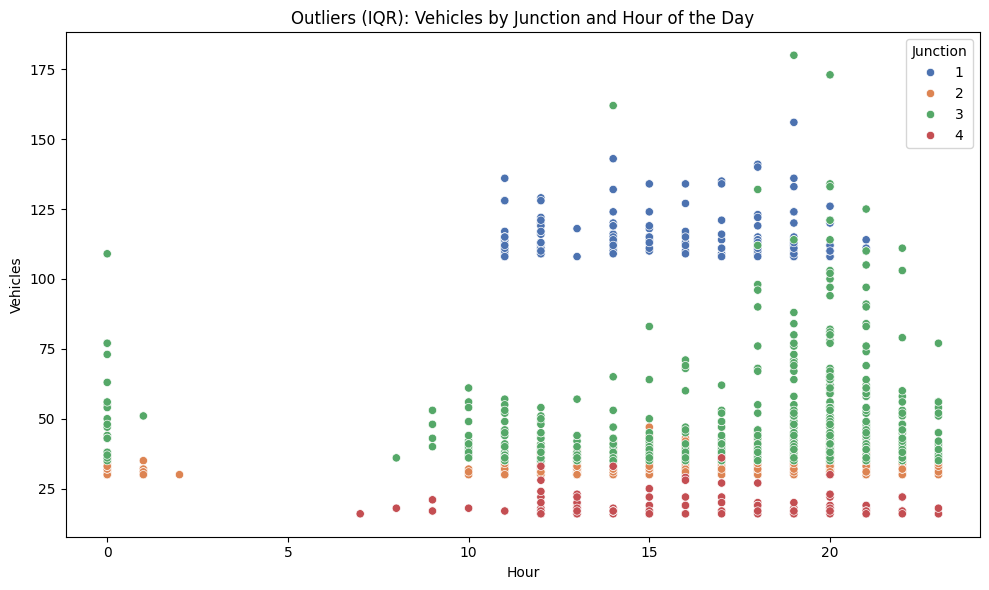

In [33]:
# Ensure DateTime is in datetime format for outliers_iqr
outliers_iqr['DateTime'] = pd.to_datetime(outliers_iqr['DateTime'])  # Confirming for outliers_iqr

# Create the hour column for outliers_iqr
outliers_iqr['hour'] = outliers_iqr['DateTime'].dt.hour

# Plotting outliers detected by IQR method by hour
plt.figure(figsize=(10, 6))
sns.scatterplot(x='hour', y='Vehicles', hue='Junction', data=outliers_iqr, palette='deep')
plt.title('Outliers (IQR): Vehicles by Junction and Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Vehicles')
plt.tight_layout()
plt.show()

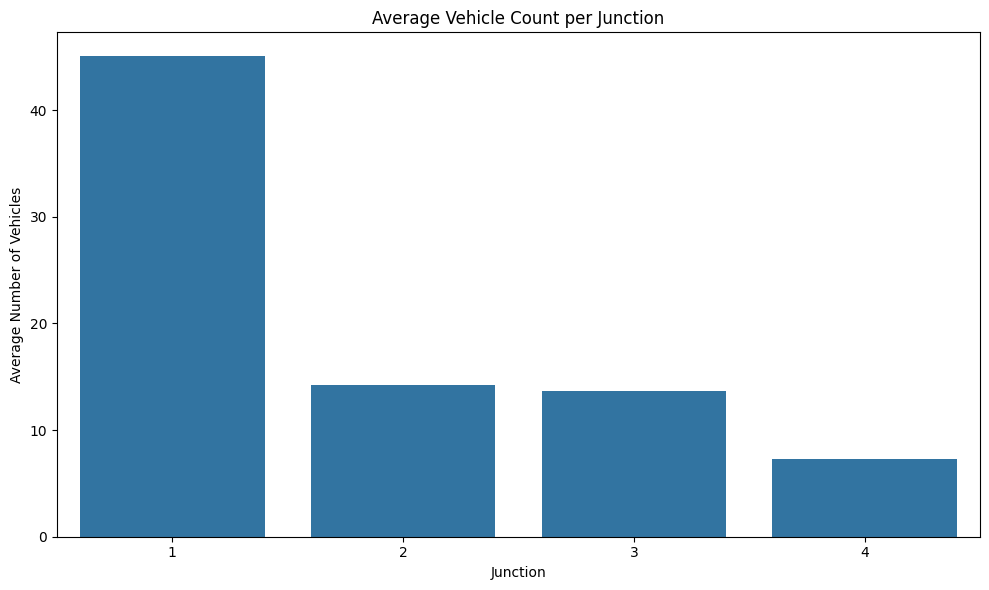

In [34]:
# Bar plot of average vehicle count per junction
plt.figure(figsize=(10, 6))
avg_vehicles = df.groupby('Junction')['Vehicles'].mean().reset_index()
sns.barplot(x='Junction', y='Vehicles', data=avg_vehicles)
plt.title('Average Vehicle Count per Junction')
plt.xlabel('Junction')
plt.ylabel('Average Number of Vehicles')
plt.tight_layout()
plt.show()

In [35]:
# Interactive plot (optional, using Plotly)
import plotly.express as px

In [36]:
# Interactive scatter plot for outliers detected by Isolation Forest
fig = px.scatter(outliers_iso, x='DateTime', y='Vehicles', color='Junction', title='Interactive Outlier Detection (Isolation Forest)')
fig.show()

In [37]:
# Memory optimization: downcasting numerical columns
df['Vehicles'] = pd.to_numeric(df['Vehicles'], downcast='integer')
df['Junction'] = pd.to_numeric(df['Junction'], downcast='integer')

In [38]:
print("\nMemory optimized dataframe info:")
df.info()


Memory optimized dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   DateTime         48120 non-null  datetime64[ns]
 1   Junction         48120 non-null  int8          
 2   Vehicles         48120 non-null  int16         
 3   ID               48120 non-null  int64         
 4   Vehicles_scaled  48120 non-null  float64       
 5   outlier          48120 non-null  int32         
 6   day_of_week      48120 non-null  object        
 7   hour             48120 non-null  int32         
 8   is_weekend       48120 non-null  int32         
 9   is_peak_hour     48120 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int16(1), int32(4), int64(1), int8(1), object(1)
memory usage: 2.3+ MB
